# Early Fusion Model - CMU-MOSI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 535 (delta 0), reused 11 (delta 0), pack-reused 521 (from 2)
Receiving objects: 100% (535/535), 347.93 MiB | 47.89 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [3]:
import gdown

file_id = "1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU"
destination = "mosi_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=ad6321db-622e-4c0d-99fe-4d2f29f64bf8
To: /content/mosi_raw.pkl
100%|██████████| 357M/357M [00:02<00:00, 170MB/s]


'mosi_raw.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import GRU, MLP, Sequential, Identity
from training.supervised import train, test
from fusions.modules import ConcatEarly
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
train_data, valid_data, test_data = get_dataloader('/content/mosi_raw.pkl', max_pad=True, max_seq_len=50)

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
encoders = [Identity().to(device), Identity().to(device), Identity().to(device)]
head = Sequential(
    GRU(
        409,
        512,
        dropout=True,
        has_padding=False,
        batch_first=True,
        last_only=True,
    ),
    MLP(512, 512, 1),
).to(device)


In [9]:
fusion = ConcatEarly().to(device)

## Training

In [10]:
OUTPUT_MODEL_FILE_NAME = 'MOSI_Early_Fusion'

In [11]:
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    is_packed=False,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 1.3447
Valid Loss: 1.3735
Saving Best

Epoch [2/100]
Train Loss: 1.3230
Valid Loss: 1.3909

Epoch [3/100]
Train Loss: 1.3182
Valid Loss: 1.3820

Epoch [4/100]
Train Loss: 1.3142
Valid Loss: 1.3875

Epoch [5/100]
Train Loss: 1.3169
Valid Loss: 1.3684
Saving Best

Epoch [6/100]
Train Loss: 1.3183
Valid Loss: 1.3875

Epoch [7/100]
Train Loss: 1.3192
Valid Loss: 1.3897

Epoch [8/100]
Train Loss: 1.3160
Valid Loss: 1.3850

Epoch [9/100]
Train Loss: 1.3181
Valid Loss: 1.3833

Epoch [10/100]
Train Loss: 1.3184
Valid Loss: 1.3899

Epoch [11/100]
Train Loss: 1.3161
Valid Loss: 1.3887

Epoch [12/100]
Train Loss: 1.3214
Valid Loss: 1.3906

Epoch [13/100]
Train Loss: 1.2901
Valid Loss: 1.4634

Epoch [14/100]
Train Loss: 1.2870
Valid Loss: 1.4631

Epoch [15/100]
Train Loss: 1.2217
Valid Loss: 1.3163
Saving Best

Epoch [16/100]
Train Loss: 1.1752
Valid Loss: 1.2674
Saving Best

Epoch [17/100]
Train Loss: 1.0542
Valid Loss: 1.4371

Epoch [18/100]
Train Loss: 0.9775
Valid Los

Text(0.5, 1.0, 'Loss vs. No. of epochs')

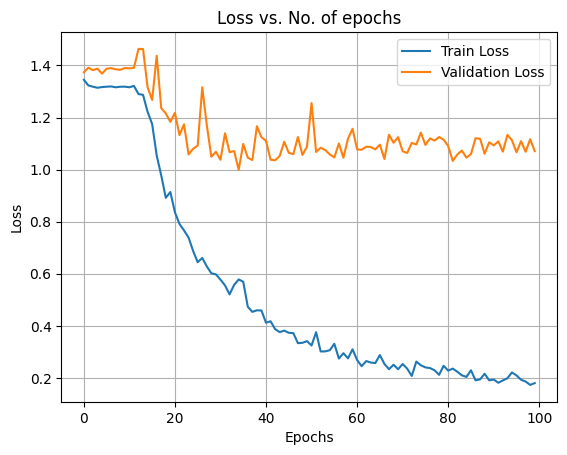

In [12]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [13]:
save_results(train_losses, valid_losses, f"/content/{OUTPUT_MODEL_FILE_NAME}.pkl")

## Testing

In [14]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_data,
    is_packed=False,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-14-7fdfb79d3e40>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Recall: 68.1402% | Total Accuracy: 66.9096%
Inference Time: 231ms
Inference Params: 1680897
